# Assignment 5

**Assignment 5: Neuroevolution: Neural Architecture Search (NAS)**

**Goal**: Get familiar with neural architecture search by applying an evolutionary algorithm to
select the best architecture of a neural network.

In this assignment, we are going to use an evolutionary algorithm for selecting the best architecture of a neural network. As such, this assignment can be seen as a combination of assignment 3 and assignment 4. Similar to assignment 4, the neural network is trained on images.

In this task, the code for a neural network must be implemented in PyTorch.

## 1. Implementation

**Data Loaders**

See assignment 4.


**Neuroevolution for NAS**
1. In this assignment, we are interested in implementing a convolutional neural network of the following form:
    Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax
    However, we allow different choices in each building block:
        Conv2d:
            Number of filters: 8, 16, 32
            kernel=(3,3), stride=1, padding=1 OR kernel=(5,5), stride=1, padding=2
        f(.):
            ReLU OR sigmoid OR tanh OR softplus OR ELU
        Pooling:
            2x2 OR Identity
            Average OR Maximum
        Linear 1:
            Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
        Altogether, there are 4500 possible configurations.
2. Think of how to represent these options (e.g., binary variables, one-hot-representation, integers).
3. Adapt the implementation from assignment 4 accordingly so that a network could be easily created for given options.
4. Implement an evolutionary algorithm for NAS:
    Think of appropriate mutation, recombination, and selection for chosen representation.
    Modify the objective function (i.e., classification error, ClassError) by adding a penalty for the number of weights in the CNN:
        Objective = ClassError + λ𝑁_𝑝/𝑁_𝑚𝑎𝑥
    where 𝑁_𝑝 denotes the number of weights of a model and is a number of 𝑁𝑚𝑎𝑥 weights of the largest possible neural network in the search space.
        Take λ = 0.01
    Each candidate network is trained for a couple of epochs (e.g., up to 10) in order to avoid potential problems with learning times.
5. Evaluate the best-performing candidate network on the test set.
    Please notice that we train a CNN using the cross-entropy, but in the evolutionary algorithm, we use the classification error on the validation set!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import scipy.stats as ss
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits

In [2]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""
    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample_x = self.data[idx].reshape(-1, 8, 8)
        sample_y = torch.tensor(self.targets[idx]) 
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [3]:
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        self.classnet = classnet
        self.nll = nn.NLLLoss(reduction='none')

    def classify(self, x):
        x = self.classnet(x)
        y_pred = torch.argmax(x, dim=1)

        return y_pred
    
    def forward(self, x, y, reduction='avg'):
        loss = self.nll(self.classnet(x),y.long())
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

In [31]:
class CNN_Choices:
    def __init__(self):
        # the possible activation functions
        self.activation_funct = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()]
        # possible number of filters
        self.num_filter = [8, 16, 32]
    
    # the two ways the conv2d can be set up with kernel and padding
    def conv2d_options(self, filters, block):
        if block: 
            kernel = 3
            padding = 1
        else: 
            kernel = 5
            padding = 2
        stride = 1
        # the actual conv2d function with the possible kernel and padding options
        return nn.Conv2d(1, self.num_filter[filters], kernel_size=kernel, padding=padding, stride=stride)
    
    # pooling options
    def pooling_options(self, kernel, avg_pool2d):
        kernel += 1
        if avg_pool2d:
            return nn.AvgPool2d(kernel)
        else:
            return nn.MaxPool2d(kernel)
        
    def linear1_options(self, filters, block, kernel_pool):
        if block: 
            kernel = 3
            padding = 1
        else: 
            kernel = 5
            padding = 2
        kernel_pool += 1
        lin_input = int(self.num_filter[filters] * ((8 - kernel + 2 * padding + 1) / kernel_pool) ** 2)
        return lin_input
    
    # Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax
    def configuration(self, config):
        classnet = nn.Sequential(
            self.conv2d_options(* config[:2]),
            self.activation_funct[config[2]],
            self.pooling_options(* config[3:5]),
            nn.Flatten(),
            nn.Linear(self.linear1_options(* config[np.asarray([0,1,3])]), config[5] * 10),
            self.activation_funct[config[2]],
            nn.Linear(config[5] * 10, 10),
            nn.LogSoftmax(dim=1))
        return ClassifierNeuralNet(classnet)
    
    def configurations(self, configs):
        inputs = []
        for config in configs:
            input_type = self.configuration(config)
            inputs.append(input_type)
        return np.asarray(inputs)

In [32]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [33]:
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 10 # max. number of epochs

In [40]:
class Evaluate:
    def __init__(self):
        self.CNN = CNN_Choices()
        dataset = Digits()
    
    # Get the test/validation loss and classification error
    def evaluation(self, model, test_loader):
        model.eval()
        loss_test = 0.
        loss_error = 0.
        N = 0.
        
        # start evaluation
        for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
            # loss (nll)
            loss_test_batch = model.forward(test_batch, test_targets, reduction='sum')
            loss_test = loss_test + loss_test_batch.item()
            # classification error
            y_pred = model.classify(test_batch)
            e = 1.*(y_pred == test_targets)
            loss_error = loss_error + (1. - e).sum().item()
            # the number of examples
            N = N + test_batch.shape[0]
        # divide by the number of examples
        loss_test = loss_test / N
        loss_error = loss_error / N

        return loss_test, loss_error
    
    # Main training loop
    def training(self, model, optimizer):
        for e in range(num_epochs):
            model.train() # set the model to the training mode
            # load batches
            for indx_batch, (batch, targets) in enumerate(training_loader):
                # calculate the forward pass (loss function for given images and labels)
                loss = model.forward(batch, targets)
                # remember we need to zero gradients! Just in case!
                optimizer.zero_grad()
                # calculate backward pass
                loss.backward(retain_graph=True)
                # run the optimizer
                optimizer.step()
        return model
    
    def classification_error(self, classn, repetition=3, test=False):
        f = np.zeros(classn.shape[0])
        # the evaluation is done multiple times 
        for _ in range(repetition):
            # Init ClassifierNN
            models = self.CNN.configurations(classn.reshape(-1, 6))
            # Init OPTIMIZER (here we use ADAMAX)
            for i, model in enumerate(models):
                optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], 
                                           lr=lr, weight_decay=wd) 
                model = self.training(model, optimizer)
                _, ce = self.evaluation(model, val_loader if not test else test_loader)
                f[i] += ce
        # returns the average classification error
        return f / repetition

In [41]:
class EA:
    def __init__(self, evaluator, pop_size, bounds_min, bounds_max, std=1, parents=None):
        self.evaluator = evaluator
        self.pop_size = pop_size
        self.bounds_min = np.asarray(bounds_min)
        self.bounds_max = np.asarray(bounds_max)
        self.parents = parents if parents is not None else pop_size
        self.std = std
            
    def parent_selection(self, x_old, f_old):
        index = np.random.choice(self.pop_size, self.parents) 

        x_parents = x_old[index]
        f_parents = f_old[index]

        return x_parents, f_parents
    
    # helper function for recombination
    def find_parent_options(self, x, f):
        index = np.argsort(f) # selects where x should be indexed
        x = x[index] # chooses the index of x
        x = x[:2]    # selects the first 2 items of x
        f = x[2:]    # choses the items after the first 2
        return x, f
    
    #  concatenates the parent options specified in the helper function
    def recombination(self, x_parents, f_parents):

        good_parents, bad_parents = self.find_parent_options(x_parents, f_parents)
        x_children = np.concatenate([good_parents, bad_parents])

        return x_children
    
    def mutation(self, x_children):
        rng = np.random.default_rng()
        bit_flip = rng.binomial(1, 0.2, (x_children.shape[0], 3))
        activation_funct = np.random.randint(5, size = x_children.shape[0])
        
        x_children[:,np.array([1, 3, 4])] = (x_children[:,np.array([1, 3, 4])] + bit_flip)%2 # flips bits
        x_children[:,2] = activation_funct # random mutation for activation functions

        return np.minimum(x_children, np.maximum(self.bounds_min, self.bounds_max))
    
    # survival selection 
    def survivor_selection(self, x_old, x_children, f_old, f_children):
        f = np.concatenate([f_old, f_children])
        x = np.concatenate([x_old, x_children])
        
        index = np.argsort(f)
        x = x[index]
        f = f[index]
        
        x = x[:self.pop_size]
        f = f[:self.pop_size]

        return x, f

    def evaluate(self, x):
        return self.evaluator.classification_error(x)
  
    def step(self, x_old, f_old):

        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        self.std = max(self.std - 1, 1)

        return x, f

In [44]:
num_generations = 25
pop_size = 50
bounds_min = np.asarray([0, 0, 0, 0, 0, 1])
bounds_max = np.asarray([2, 1, 4, 1, 1, 10])

# Initialize the evaluator
e = Evaluate()

# Object goes here:
ea = EA(e, pop_size, bounds_min, bounds_max)

# Init the population
x = np.random.randint(low=bounds_min, high=bounds_max, size=(pop_size, 6))
f = e.classification_error(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print('Generation: {}, best fitness: {}'.format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])

# The final evaluation (on the test set)
test_loss_error = e.classification_error(x[f.argmin()], test=True)[0]
print(f'-> FINAL PERFORMANCE: {test_loss_error}')

Generation: 0, best fitness: 0.03142857142857143
Generation: 2, best fitness: 0.029714285714285714
Generation: 4, best fitness: 0.029714285714285714
Generation: 6, best fitness: 0.029714285714285714
Generation: 8, best fitness: 0.029714285714285714
Generation: 10, best fitness: 0.029714285714285714
Generation: 12, best fitness: 0.029714285714285714
Generation: 14, best fitness: 0.029714285714285714
Generation: 16, best fitness: 0.029714285714285714
Generation: 18, best fitness: 0.029714285714285714
Generation: 20, best fitness: 0.029714285714285714
Generation: 22, best fitness: 0.029714285714285714
Generation: 24, best fitness: 0.029714285714285714
-> FINAL PERFORMANCE: 0.08277404921700222


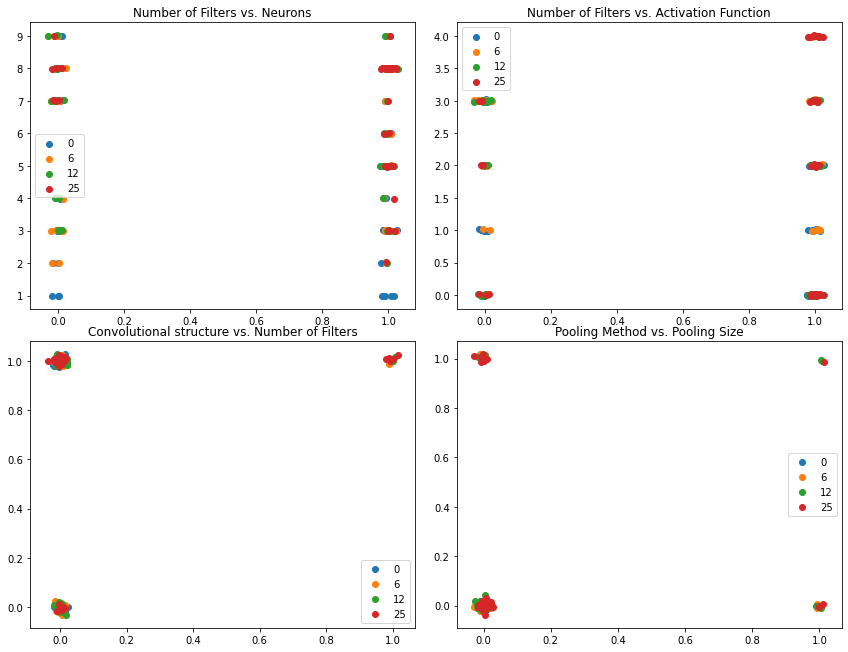

In [57]:
gens = [0, num_generations//4, num_generations//2, num_generations]
fig_ea_pops, axs = plt.subplots(2, 2, figsize=(12, 9))
fig_ea_pops.tight_layout()

for i in range(len(gens)):
    # added because otherwise the dots are directly on top of each other due to the 
    # coded values
    pop_i = populations[gens[i]] + np.random.randn(*populations[gens[i]].shape)/100
    axs[0,0].scatter(pop_i[:,0], pop_i[:,-1], label=str(gens[i]))
    axs[0,1].scatter(pop_i[:,0], pop_i[:,2], label=str(gens[i]))
    axs[1,0].scatter(pop_i[:,1], pop_i[:,0], label=str(gens[i]))
    axs[1,1].scatter(pop_i[:,3], pop_i[:,4], label=str(gens[i]))
axs[0,0].legend(), axs[0,1].legend(), axs[1,0].legend(), axs[1,1].legend()
axs[0,0].set_title('Number of Filters vs. Neurons')
axs[0,1].set_title('Number of Filters vs. Activation Function')
axs[1,0].set_title('Convolutional structure vs. Number of Filters')
axs[1,1].set_title('Pooling Method vs. Pooling Size')

plt.show()

In [58]:
model = e.CNN.configuration(x[f.argmin()])
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=wd) 
val_loss, val_error = [], []

model.train()
for _ in range(50):
    for indx_batch, (batch, targets) in enumerate(training_loader):
        loss = model.forward(batch, targets)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    loss, error = e.evaluation(model, val_loader)
    val_loss.append(loss)
    val_error.append(error)
loss, error = e.evaluation(model, test_loader)

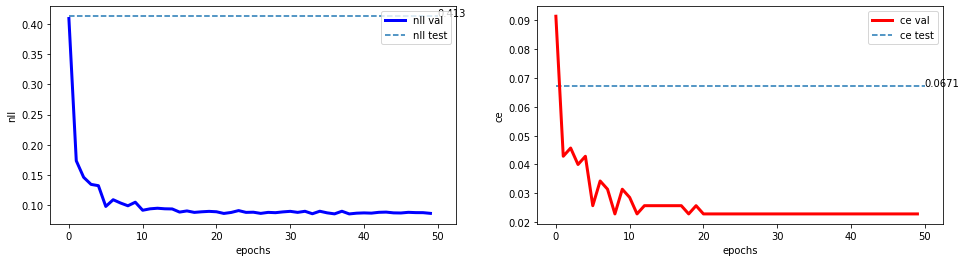

In [61]:
_, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(range(len(val_loss)), val_loss, color='blue', linewidth='3', label='nll val')
axs[0].hlines(loss, xmin=0, xmax=len(val_loss), linestyles='dashed', label='nll test')
axs[0].text(len(val_loss), loss, f"{loss:.3}")
axs[0].set_xlabel('epochs'), axs[0].set_ylabel('nll')
axs[0].legend()

axs[1].plot(range(len(val_error)), val_error, color='red', linewidth='3', label='ce val')
axs[1].hlines(error, xmin=0, xmax=len(val_loss), linestyles='dashed', label='ce test')
axs[1].text(len(val_loss), error, f"{error:.3}")
axs[1].set_xlabel('epochs'), axs[1].set_ylabel('ce')
axs[1].legend()

plt.show()